(4194304,)
(16777216,)
(40960,)


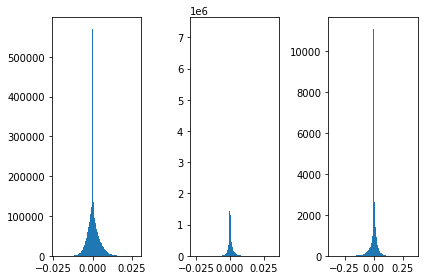

In [14]:
import torch
import matplotlib.pyplot as plt
from toy import AlexNet

model = AlexNet(10)

chk = torch.load('out3/checkpoint.tar')
model.load_state_dict(chk['state_dict'])

w1 = w2 = w3 = []
for name, param in model.named_parameters():
    if name == 'classifier.1.weight':
        w1 = param.flatten().data.numpy() # 4194304
    elif name == 'classifier.4.weight':
        w2 = param.flatten().data.numpy() # 16777216
    elif name == 'classifier.6.weight':
        w3 = param.flatten().data.numpy() # 4096

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].hist(w1, bins=200, range=(-0.02, 0.02))
axs[1].hist(w2, bins=200, range=(-0.02, 0.02))
axs[2].hist(w3, bins=200, range=(-0.2, 0.2))
fig.show()

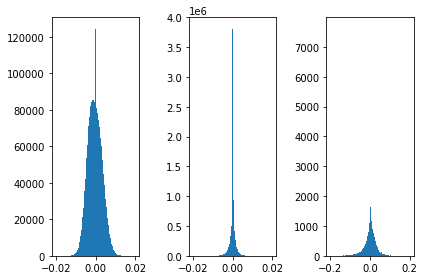

In [17]:
import torch
import matplotlib.pyplot as plt
from toy import AlexNet

model2 = AlexNet(10)

chk = torch.load('out3/model_best.pth.tar')
model2.load_state_dict(chk['state_dict'])

w1 = w2 = w3 = []
for name, param in model2.named_parameters():
    if name == 'classifier.1.weight':
        w1 = param.flatten().data.numpy() # 4194304
    elif name == 'classifier.4.weight':
        w2 = param.flatten().data.numpy() # 16777216
    elif name == 'classifier.6.weight':
        w3 = param.flatten().data.numpy() # 4096

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].hist(w1, bins=200, range=(-0.02, 0.02))
axs[1].hist(w2, bins=200, range=(-0.02, 0.02))
axs[2].hist(w3, bins=200, range=(-0.2, 0.2))
fig.show()

In [ ]:
def aug(image, preprocess):
    mixture_width = 3
    mixture_depth = 1
    aug_severity = 3

    aug_list = augmentations.augmentations_all

    ws = np.float32(np.random.dirichlet([1] * mixture_width))
    m = np.float32(np.random.beta(1, 1))
    
    mix = torch.zeros_like(preprocess(image))
    for i in range(mixture_width):
        image_aug = image.copy()
        depth = mixture_depth if mixture_depth > 0 else np.random.randint(1, 4)
    for _ in range(depth):
        op = np.random.choice(aug_list)
        image_aug = op(image_aug, aug_severity)
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * preprocess(image_aug)

    mixed = (1 - m) * preprocess(image) + m * mix
    return mixed


class AugMixDataset(torch.utils.data.Dataset):
    """Dataset wrapper to perform AugMix augmentation."""

    def __init__(self, dataset, preprocess, no_jsd=False):
        self.dataset = dataset
        self.preprocess = preprocess
        self.no_jsd = no_jsd

    def __getitem__(self, i):
        x, y = self.dataset[i]
        if self.no_jsd:
            return aug(x, self.preprocess), y
        else:
            im_tuple = (self.preprocess(x), aug(x, self.preprocess),aug(x, self.preprocess))
        return im_tuple, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

from toy import AlexNet
import augmentations

# Make Original & AugMix DataLoader
transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, padding=4)])
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5]*3, [0.5]*3)])
origin_loader = DataLoader(datasets.CIFAR10("/dataset/CIFAR",train=False,transform=preprocess), batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

augmix_data = datasets.CIFAR10('/dataset/CIFAR',train=False,transform=transform)
augmix_data = AugMixDataset(augmix_data, preprocess)
augmix_loader = DataLoader(augmix_data, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


# Load model
model = AlexNet(10)
chk = torch.load("out/checkpoint.tar")
model.load_state_dict(chk['state_dict'])

# Evaluate Original Model Activation Variance
